## Prediction of Hip Replacement from OAI Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#### Enrollees data (general information about people in the study)

In [3]:
ENROLLEES = pd.read_csv('Comma Delimited Data/enrollees.csv').drop(['VERSION'],axis=1)
ENROLLEES = ENROLLEES[['ID','P02HISP','P02SEX', 'P02RACE']]

#### Target Data (outcomes99.csv)

In [4]:
dt = pd.read_csv('Comma Delimited Data/outcomes99.csv').drop(['version'],axis=1)

#### Grouping features names by meaning...

In [368]:
tRPCF = [i for i in dt.columns if i[-4:] =='RPCF']   # Knee and hip replacement status during follow-up
tKRPCF = [i for i in dt.columns if i[-5:] =='KRPCF']   # Knee replacement status during follow-up
tHRPCF = [i for i in dt.columns if i[-5:] =='HRPCF']   # Hip replacement status during follow-up
tBLRP = [i for i in dt.columns if i[-4:] =='BLRP']   # Baseline knee or hip replacements
tRPSN = [i for i in dt.columns if i[-4:] =='RPSN']   # Knee or hip replacement seen on follow-up OAI x-ray.
tDAYS = [i for i in dt.columns if i[-4:] =='DAYS']   # Closest OAI contact prior to and after replacement
tVSPR = [i for i in dt.columns if i[-4:] =='VSPR']   # Closest OAI contact prior to replacement
tKVSPR = [i for i in dt.columns if i[-5:] =='KVSPR']   # Closest OAI contact prior to Knee replacement
tHVSPR = [i for i in dt.columns if i[-5:] =='HVSPR']   # Closest OAI contact prior to Hip replacement
tXRPR = [i for i in dt.columns if i[-4:] =='XRPR']   # Closest OAI visit with x-ray prior to replacement
tXRAF = [i for i in dt.columns if i[-4:] =='XRAF']   # Closest OAI visit with x-ray after the replacement

tVSAF = [i for i in dt.columns if i[-4:] =='VSAF']   # Closest OAI contact after the replacement
tDATE = [i for i in dt.columns if i[-4:] =='DATE']   # Date of a replacement
tTLPR = [i for i in dt.columns if i[-4:] =='TLPR']   # Total or Partial replacement indication
tTPPR = [i for i in dt.columns if i[-4:] =='TPPR']   # Type of Partial replacement indication
tPODX = [i for i in dt.columns if i[-4:] =='PODX']   # Primary pre-operative diagnosis
tDEATH = [i for i in dt.columns if i[-4:] =='EDDCF'] # Death columns

DT_outcome = dt[['id'] + tHRPCF + tBLRP + tPODX + tHVSPR + tDEATH + tDAYS]

In [369]:
DT_outcome.head()

,id,V99ERHRPCF,V99ELHRPCF,V99ERKBLRP,V99ELKBLRP,V99ERHBLRP,V99ELHBLRP,V99ERKPODX,V99ELKPODX,V99ERHPODX,V99ELHPODX,V99ERHVSPR,V99ELHVSPR,V99ERKDAYS,V99ELKDAYS,V99ERHDAYS,V99ELHDAYS
0,9000099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9000296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9000622,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9000798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9001104,NaN,3.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,2091.0


#### Grouping features names by affected joint ...

In [7]:
tELK = [i for i in DT_outcome.columns if i[0:6] =='V99ELK']  # Left Knee Columns
tERK = [i for i in DT_outcome.columns if i[0:6] =='V99ERK']  # Right Knee Columns
tELH = [i for i in DT_outcome.columns if i[0:6] =='V99ELH']  # Left Hip Columns
tERH = [i for i in DT_outcome.columns if i[0:6] =='V99ELH']  # Right Hip Columns
DT_outcome[['id'] + tERH].head(5)

,id,V99ELHRPCF,V99ELHBLRP,V99ELHPODX,V99ELHVSPR
0,9000099,NaN,NaN,NaN,NaN
1,9000296,NaN,NaN,NaN,NaN
2,9000622,NaN,0.0,NaN,NaN
3,9000798,NaN,NaN,NaN,NaN
4,9001104,3.0,0.0,4.0,3.0


In [8]:
targets = DT_outcome.fillna(0)
targets.describe()

,id,V99ERHRPCF,V99ELHRPCF,V99ERKBLRP,V99ELKBLRP,V99ERHBLRP,V99ELHBLRP,V99ERKPODX,V99ELKPODX,V99ERHPODX,V99ELHPODX,V99ERHVSPR,V99ELHVSPR
count,4.796000e+03,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000,4796.000000
mean,9.513826e+06,0.072977,0.067973,0.007923,0.005213,0.006047,0.004379,0.065680,0.071309,0.031902,0.035029,0.139491,0.134696
std,2.794781e+05,0.459963,0.442252,0.088669,0.072018,0.077533,0.066033,0.333187,0.408362,0.263180,0.313783,1.006929,0.995190
min,9.000099e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.283430e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.522042e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.747572e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.999878e+06,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,8.000000,8.000000,10.000000,10.000000


### AllClinicalDataset

Reading the data for the joint dataset...

Here, we are trying to consider only the __last visit__, prior to a replacement. We're trying to catch information that refers to a condition before the surgery.

So:
1. Reading datasets from files. Dropping some columns we won't use
2. Renaming columns, changing.. VxxKPNL12, VxxKPNLEVY to... KPNL12, KPNLEVY, etc..   and refering the visit number in a separated column, named 'visit'. (So we can compare variable between the visits)
3. Joining with the information of last visit prior to a replacement.  (this generates a dataset that have one line per visit... per each ID)
4. Keeping just the last visit (-1) prior to replacement, or a specific visit, for each ID.

In [277]:
dt0 = pd.read_csv('Comma Delimited Data/allclinical01.csv').drop(['VERSION'],axis=1)
dt1 = pd.read_csv('Comma Delimited Data/allclinical02.csv').drop(['VERSION'],axis=1) 
dt2 = pd.read_csv('Comma Delimited Data/allclinical03.csv').drop(['VERSION'],axis=1)
dt3 = pd.read_csv('Comma Delimited Data/allclinical04.csv').drop(['VERSION'],axis=1) 
dt4 = pd.read_csv('Comma Delimited Data/allclinical05.csv').drop(['VERSION'],axis=1) 
dt5 = pd.read_csv('Comma Delimited Data/allclinical06.csv').drop(['VERSION'],axis=1) 
dt6 = pd.read_csv('Comma Delimited Data/allclinical07.csv').drop(['VERSION'],axis=1) 
dt7 = pd.read_csv('Comma Delimited Data/allclinical08.csv').drop(['VERSION'],axis=1) 
dt8 = pd.read_csv('Comma Delimited Data/allclinical09.csv').drop(['VERSION'],axis=1) 
dt9 = pd.read_csv('Comma Delimited Data/allclinical10.csv').drop(['VERSION'],axis=1) 
dt10 = pd.read_csv('Comma Delimited Data/allclinical11.csv').drop(['VERSION'],axis=1)

##### Renaming columns (removing Vxx to enable direct comparison between visits)

the visit number information is kept in the 'visit' column

In [278]:
dts = [dt0,dt1,dt2,dt3,dt4,dt5,dt6,dt7,dt8,dt9,dt10]
for j in range(len(dts)):
    d = dts[j]
    col = list(d.columns)
    for i in range(1,len(col)):
        txtcol = col[i]
        col[i] = txtcol[3:]
    d.columns=col
    d['visit'] = j  
ALLDATA = pd.concat(dts,sort=False)

In [279]:
# getting information about the last contact prior to replacement...
visit_to_keep = -1
if visit_to_keep != -1:
    DT_outcome['prior_visit'] = visit_to_keep
else:
    DT_outcome['prior_visit'] = DT_outcome[tHVSPR].max(axis=1).fillna(10) # Last visit prior to replacement...


ALLDATA_VISITS = ALLDATA.merge(DT_outcome[['prior_visit','id']],left_on='ID', right_on='id', how='outer')
ALLDATA_VISITS.head()

,ID,BLDRAW2,ILLPWK2,MULTST2,URINOB1,PLAQHR1,BLUPMN2,HOURSP2,VCOLL2,ILLPWK1,...,ACT37A,ACT37B,ACT37C,ACT37D,ACTNAA,ACTNAB,ACTNAC,ACTNAD,prior_visit,id
0,9000099,NaN,NaN,NaN,1.0,33600.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
1,9000099,NaN,NaN,NaN,1.0,27300.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
2,9000099,NaN,NaN,NaN,1.0,53700.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
3,9000099,NaN,NaN,NaN,1.0,29700.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099
4,9000099,NaN,NaN,NaN,1.0,27600.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,9000099


In [280]:
all_before = True  # 'True' keeps all visits before visit_to_keep, 'False' keeps only visit_to_keep
if all_before:
    ALLDATA_VISITS = ALLDATA_VISITS[ALLDATA_VISITS['prior_visit'] >= ALLDATA_VISITS['visit']]
else:
    # keeping information of only the last visit
    ALLDATA_VISITS = ALLDATA_VISITS[ALLDATA_VISITS['prior_visit'] == ALLDATA_VISITS['visit']]

In [281]:
ALLDATA_VISITS['lifetime_visits'] = ALLDATA_VISITS['prior_visit'] - ALLDATA_VISITS['visit']
ALLDATA_VISITS['failure_'] = 1
ALLDATA_VISITS['failure_'][ALLDATA_VISITS['prior_visit'] == 10] = 0

In [282]:
print(ALLDATA_VISITS[['visit', 'prior_visit','lifetime_visits','id']].head())
ALLDATA_VISITS = ALLDATA_VISITS.drop(['id'],axis=1)

   visit  prior_visit  lifetime_visits       id
0      0         10.0             10.0  9000099
1      2         10.0              8.0  9000099
2      3         10.0              7.0  9000099
3      4         10.0              6.0  9000099
4      5         10.0              5.0  9000099


In [283]:
#######
# Considering to drop the columns below

tSREPHR = [i for i in ALLDATA_VISITS.columns if i[0:4] =='SREP']   # Ever have replacement surgery where all or part of joint was replaced, self-report
tPSDATE = [i for i in ALLDATA_VISITS.columns if i =='PSDATE']   # Date MRI Safety Screener completed
tSSDATE = [i for i in ALLDATA_VISITS.columns if i =='SSDATE']   # 
tObjects = list(ALLDATA_VISITS.dtypes[ALLDATA_VISITS.dtypes == 'object'].keys())

to_drop = tSREPHR + tPSDATE + tSSDATE + tObjects


ALLDATA_VISITS = ALLDATA_VISITS.drop(to_drop,axis=1)

##### Aggregating all visits by mean, grouped by ID...

# Training and Testing Features

In [284]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import lightgbm as lgb

In [285]:
target_name = tHRPCF  # choosing replacement adjucation features

# merging targets with jointsx dataset
DATASET = ALLDATA_VISITS.merge(DT_outcome[target_name + ['id']], left_on='ID', right_on='id', how='outer')

train_target_X = DATASET[target_name].sum(axis=1)   ## summing all the replacements
train_target_X = train_target_X.fillna(0)     # if no information, then 0
train_target_X[train_target_X >= 1] = 1       # if greater than 0... at least one replacement occurred

train_features, test_features, train_target, test_target = train_test_split(DATASET, train_target_X, test_size = 0.3)

IDs = train_features['ID']
FAILURES = train_features['failure_']
LAST_VISITS = train_features['prior_visit']
VISITS = train_features['visit']
LIFETIME = train_features['lifetime_visits']

test_IDs = test_features['ID']
test_FAILURES = test_features['failure_']
test_LAST_VISITS = test_features['prior_visit']
test_VISITS = test_features['visit']
test_LIFETIME = test_features['lifetime_visits']

X = DATASET.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits'] + target_name,axis=1)
train_features = train_features.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits'] + target_name,axis=1)
test_features = test_features.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits'] + target_name,axis=1)

#X = X #.fillna(-1)
#X = pd.get_dummies(X)

print('Targets: ', target_name)
print('Dataset: ', ALLDATA_VISITS.shape)
print('Train dataset:', train_features.shape)
print('Test dataset:', test_features.shape)

Targets:  ['V99ERHRPCF', 'V99ELHRPCF']
Dataset:  (43161, 1400)
Train dataset: (30212, 1395)
Test dataset: (12949, 1395)


#### Measuring feature importances

In [89]:
# Create the model with several hyperparameters
model = lgb.LGBMClassifier(learning_rate=0.01, max_depth=5,objective='binary', boosting_type = 'gbdt', n_estimators = 3000)

# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X.shape[1])

iterations = 1
# Fit the model twice to avoid overfitting
for i in range(iterations):
    
    # Split into training and validation set
    train_dt, valid_dt, train_y, valid_y = train_test_split(X, train_target_X, test_size = 0.25, random_state = i)

    print('======================================================================== ')        
    # Train using early stopping
    model.fit(train_dt, train_y, early_stopping_rounds=100, 
              eval_set = [(valid_dt, valid_y)], eval_metric = 'binary_logloss', verbose = 200)

    print('\n===========================================================\nModel ') 
    valid_pred = model.predict_proba(valid_dt, num_iteration=model.best_iteration_)
    vmetrics = confusion_matrix(valid_y,np.argmax(valid_pred,axis=1))
    
    print ('TN',vmetrics[0,0],', FN',vmetrics[1,0],', FP',vmetrics[0,1],', TP',vmetrics[1,1])
    #fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_pred[:,1])
    #print('AUC = ', metrics.auc(fpr, tpr))  
    print('AUC = ', roc_auc_score(valid_y,valid_pred[:,1]))    
    print ('Acc:', (vmetrics[0,0] + vmetrics[1,1]) / len(valid_y))
    
    print('==============')
    print('\n0 Frequency: ', (1 - valid_y.sum()/len(valid_y)))
    print('\n1 Frequency: ', valid_y.sum()/len(valid_y))
   
    print('\n==================================\nBASELINE') 
    valid_pred = np.zeros(len(valid_y))
    baseline = confusion_matrix(valid_y,valid_pred)
    fpr, tpr, thresholds = metrics.roc_curve(valid_y, valid_pred)
    print ('TN',baseline[0,0],', FN',baseline[1,0],', FP',baseline[0,1],', TP',baseline[1,1])
    print('AUC = ', metrics.auc(fpr, tpr))
    print ('Acc:', (baseline[0,0] + baseline[1,1]) / len(valid_y))
    
    # Record the feature importances
    feature_importances += model.feature_importances_

feature_importances /= iterations

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.09392
[400]	valid_0's binary_logloss: 0.0908932
[600]	valid_0's binary_logloss: 0.0893654
[800]	valid_0's binary_logloss: 0.0885362
[1000]	valid_0's binary_logloss: 0.0878998
[1200]	valid_0's binary_logloss: 0.0875073
[1400]	valid_0's binary_logloss: 0.0873404
[1600]	valid_0's binary_logloss: 0.0872186
Early stopping, best iteration is:
[1666]	valid_0's binary_logloss: 0.0871694

Model 
TN 10507 , FN 240 , FP 4 , TP 40
AUC =  0.871169149327
Acc: 0.977388564545

0 Frequency:  0.974052451117

1 Frequency:  0.0259475488833

BASELINE
TN 10511 , FN 280 , FP 0 , TP 0
AUC =  0.5
Acc: 0.974052451117


In [90]:
feature_importances = pd.DataFrame({'feature': list(train_features.columns), 'importance': feature_importances}
                                  ).sort_values('importance', ascending = False)

# Find the features with zero importance
least_important = list(feature_importances[feature_importances['importance'] <= 0]['feature'])
print('There are %d no important features' % len(least_important))

There are 656 no important features


In [91]:
feature_importances.head(10)

,feature,importance
607,VISDYS,711.0
260,HSPSS,545.0
537,BMI,544.0
592,AGE,543.0
534,WEIGHT,392.0
586,REASON,391.0
322,HRS12,381.0
182,KOOSFX1,372.0
248,HSMSS,366.0
359,OAH12CV,345.0


In [92]:
train_features = train_features.drop(columns = least_important)
test_features = test_features.drop(columns=least_important)

print('Resulting Training shape: ', train_features.shape)
print('Testing shape: ', test_features.shape)

Resulting Training shape:  (30212, 739)
Testing shape:  (12949, 739)


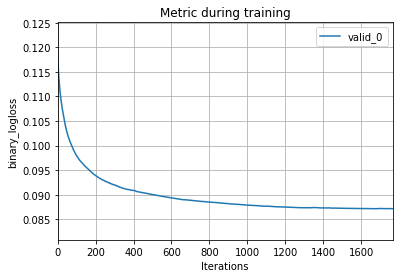

Plot feature importances...


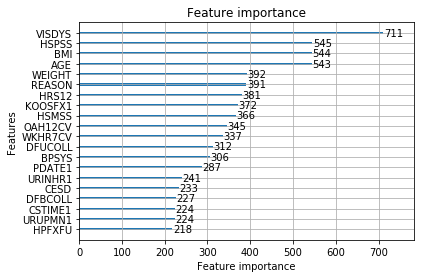

In [93]:
ax = lgb.plot_metric(model, metric='binary_logloss')
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

#### Helper functions

In [153]:
def printConfusionMatrix(test_pred, test_target ,threshold = 0.5):
    pred = np.where(test_pred > threshold, 1., 0.)
    vmetrics = confusion_matrix(test_target, pred)
    print ('TN',vmetrics[0,0],', FN',vmetrics[1,0],', FP',vmetrics[0,1],', TP',vmetrics[1,1])
    print('AUC = ', roc_auc_score(test_target, test_pred))
    print('AUC_classifier = ', roc_auc_score(test_target, pred))
    print ('Acc:', (vmetrics[0,0] + vmetrics[1,1]) / len(test_target))

In [95]:
def printTreeN(model,tree_number=0):

    print('Plot tree ', tree_number)  # one tree use categorical feature to split
    ax = lgb.plot_tree(model, tree_index=tree_number, figsize=(200, 80), show_info=['split_gain'])
    plt.show()

    print('Plot tree with graphviz...')
    graph = lgb.create_tree_digraph(model, tree_index=10, name='Tree')
    graph.render(view=True)

In [96]:
def plotROC(test_target,test_pred):

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = metrics.roc_curve(test_target, test_pred)
    plt.plot(fpr,tpr, label='(area = {:.3f})'.format(metrics.auc(fpr, tpr)))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

def plotImportances(model,max_num_features=20):

    print('Plot feature importances...')
    ax = lgb.plot_importance(model, max_num_features=max_num_features)
    plt.show()

In [185]:
def TrainAndTest(train_features, train_target, test_features, test_target, boosting_type='gbdt', max_depth=20, n_estimators = 10000,objective='binary',validation_split=0.25, iterations = 10, Testing = False, testing_model=None):

    assert train_features.shape[1] == test_features.shape[1]
    assert train_features.shape[0] == train_target.shape[0]
    assert test_features.shape[0] == test_target.shape[0]
    
    # Fit the model twice to avoid overfitting
    for i in range(iterations):

        if not Testing:
            model = lgb.LGBMClassifier(learning_rate=0.01, max_depth=max_depth, objective=objective, 
                                       boosting_type = boosting_type, n_estimators = n_estimators)
        else:
            model = testing_model

        print('\n=========================================================')
        # splitting test and train dataset...
        print('train: ', train_features.shape, ' test: ' ,test_features.shape)

        # splitting validation and train dataset...
        train_X, valid_X, train_y, valid_y = train_test_split(train_features, train_target, test_size = validation_split)

        if not Testing:
            model.fit(train_X, train_y, early_stopping_rounds=100, eval_set = [(valid_X, valid_y)], eval_metric = 'binary_logloss', verbose = 200)

        print('\n==== Testing best iteration ====')
        test_pred = model.predict_proba(test_features, num_iteration=model.best_iteration_)

        #vmetrics = confusion_matrix(test_target, np.argmax(test_pred,axis=1))
        #print ('TN',vmetrics[0,0],', FN',vmetrics[1,0],', FP',vmetrics[0,1],', TP',vmetrics[1,1])
        if objective=='binary':
            printConfusionMatrix(test_pred[:,1],test_target)
            plotROC(test_target,test_pred[:,1])
   
    return model, test_pred

## Testing


train:  (30212, 739)  test:  (12949, 739)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.098117
[400]	valid_0's binary_logloss: 0.0958658
Early stopping, best iteration is:
[397]	valid_0's binary_logloss: 0.0958331

==== Testing best iteration ====
[[ 0.99233013  0.00766987]
 [ 0.98130325  0.01869675]
 [ 0.98281398  0.01718602]
 ..., 
 [ 0.99029146  0.00970854]
 [ 0.99818981  0.00181019]
 [ 0.98754855  0.01245145]]
TN 12624 , FN 261 , FP 4 , TP 60
AUC =  0.86080923863
Acc: 0.979535099235


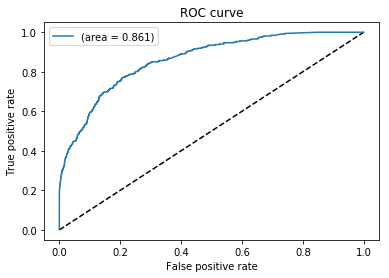

Plot feature importances...


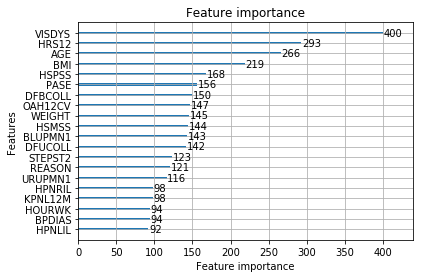

In [103]:
model = TrainAndTest(train_features,train_target,test_features,test_target, iterations=1)
plotImportances(model)

### Analysis for Time 1 (probability of replacement during next year)

To do this, we create target variables to represent a point in time of the data, related to the point in time of a replacement. We use the feature `lifetime_visits` to create the following variables:
- `target_f` that indicates if a person will have a hip replacement during the next year, from a specific visit. 
- `target_ff` (cumulative) that indicates if a person will have a hip replacement during the next period of analysis (in this case, 1 yr), from a specific visit.
- `target_t` that indicates if a person will survive (will not have a replacement) during certain period of analysis (in this case, 1 yr).
    

In [338]:
def getTimeSpecific(data,time_t_to_predict = 1, drop_columns=True, drop_censored=False, tg_name='target_f', MAX_T = 10):
    dt = data[:]
    dt['target_t'] = 0   # 1 if person should survive more than time_t_to_predict, 0 otherwise...  
    dt['target_f'] = 0   # 1 if person should die at time_t_to_predict, 0 otherwise... 
    dt['target_ff'] = 0  # 1 if person should die until time_t_to_predict, 0 otherwise... 
    dt['target_t'][dt['lifetime_visits'] >= time_t_to_predict] = 1
    dt['target_f'][dt['lifetime_visits'] == time_t_to_predict-1] = 1
    dt['target_ff'][dt['lifetime_visits'] < time_t_to_predict] = 1
    dt['target_f'][dt['prior_visit'] == MAX_T] = 0
    dt['target_ff'][dt['prior_visit'] == MAX_T] = 0
    #dt = dt[dt['lifetime_visits'] == 1]

    if drop_censored:
        dt = dt[dt['visit'] < MAX_T]
        dt = dt[(dt['lifetime_visits'] >= (time_t_to_predict)) | (dt['failure_'] == 1)]
    target = dt[tg_name]
    if drop_columns:
        dt = dt.drop(['ID','id','prior_visit','failure_', 'visit','lifetime_visits','target_f','target_t','target_ff'] + target_name,axis=1)
    
    return dt,target


train:  (26982, 1394)  test:  (11564, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.00688237
[400]	valid_0's binary_logloss: 0.00649895
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.00648505

==== Testing best iteration ====
TN 11534 , FN 6 , FP 3 , TP 21
AUC =  0.996999990369
AUC_classifier =  0.88875887242
Acc: 0.999221722587


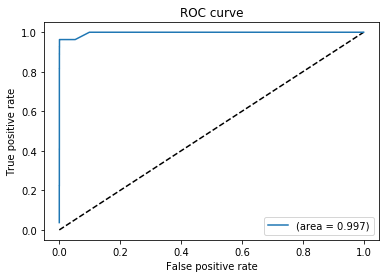


train:  (26982, 1394)  test:  (11564, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.00561855
Early stopping, best iteration is:
[240]	valid_0's binary_logloss: 0.00552813

==== Testing best iteration ====
TN 11532 , FN 3 , FP 5 , TP 24
AUC =  0.998685389038
AUC_classifier =  0.94422775033
Acc: 0.999308197855


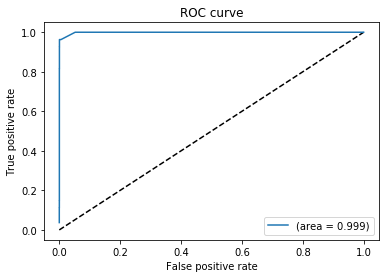


train:  (26982, 1394)  test:  (11564, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.00747862
Early stopping, best iteration is:
[261]	valid_0's binary_logloss: 0.00727763

==== Testing best iteration ====
TN 11534 , FN 7 , FP 3 , TP 20
AUC =  0.998704650737
AUC_classifier =  0.870240353902
Acc: 0.999135247319


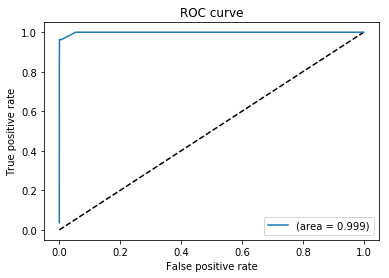

In [341]:
train_t1, target_t1 = getTimeSpecific(DATASET,time_t_to_predict=1,drop_censored=True)
#train_t1 = train_t1.drop(columns=least_important)
train_t1 = train_t1.drop(columns='REASON')
train_t1, test_t1, target_t1, test_target_t1 = train_test_split(train_t1,target_t1, test_size=0.3)

model_t1, test_pred_t1 = TrainAndTest(train_t1,target_t1,test_t1,test_target_t1, iterations=3)

Plot feature importances...


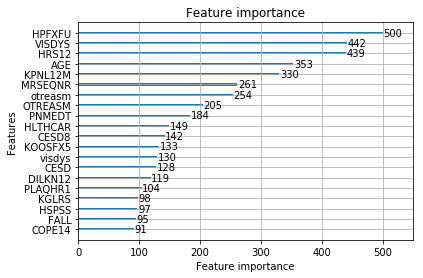

In [342]:
plotImportances(model_t1)

### Analysis for Time 2 (probability of replacement in 2 years)

To do this, we create target variables to represent a point in time of the data, related to the point in time of a replacement. We use the feature `lifetime_visits` to create the following variables:
- `target_f` that indicates if a person will have a hip replacement during the next 2 years, from a specific visit. 
- `target_ff` (cumulative) that indicates if a person will have a hip replacement exactly 2 years from a specific visit. 
- `target_t` that indicates if a person will survive (will not have a replacement) during certain period of analysis (in this case, 2 yrs).


train:  (23751, 1394)  test:  (10180, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0343344
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.0341914

==== Testing best iteration ====
TN 10079 , FN 58 , FP 9 , TP 34
AUC =  0.855409354205
AUC_classifier =  0.684336534152
Acc: 0.993418467583


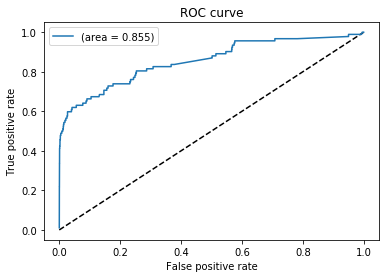


train:  (23751, 1394)  test:  (10180, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0407775
Early stopping, best iteration is:
[140]	valid_0's binary_logloss: 0.040436

==== Testing best iteration ====
TN 10083 , FN 67 , FP 5 , TP 25
AUC =  0.848398226046
AUC_classifier =  0.635621746026
Acc: 0.992927308448


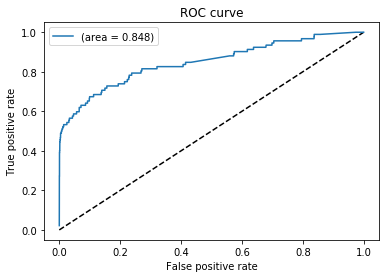


train:  (23751, 1394)  test:  (10180, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0394823
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0385004

==== Testing best iteration ====
TN 10079 , FN 56 , FP 9 , TP 36
AUC =  0.864492466297
AUC_classifier =  0.695206099369
Acc: 0.993614931238


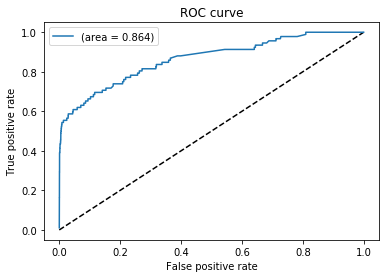

In [364]:
train_t2, target_t2 = getTimeSpecific(DATASET,time_t_to_predict=2,drop_censored=True,tg_name='target_ff')
#train_t2 = train_t2.drop(columns=least_important)
#train_t2 = train_t2.drop(columns='REASON')
train_t2 = train_t2.drop(columns='VISDYS')

train_t2, test_t2, target_t2, test_target_t2 = train_test_split(train_t2,target_t2, test_size=0.3)

model_t2, test_pred_t2 = TrainAndTest(train_t2,target_t2,test_t2,test_target_t2, iterations=3)

Plot feature importances...


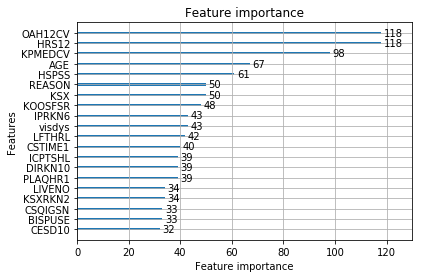

In [365]:
plotImportances(model_t2)

### Analysis for Time 3 (probability of replacement in 3 years)


train:  (20521, 1394)  test:  (8795, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0471265
Early stopping, best iteration is:
[234]	valid_0's binary_logloss: 0.0467195

==== Testing best iteration ====
TN 8672 , FN 80 , FP 6 , TP 37
AUC =  0.868125114495
AUC_classifier =  0.657773956345
Acc: 0.990221716885


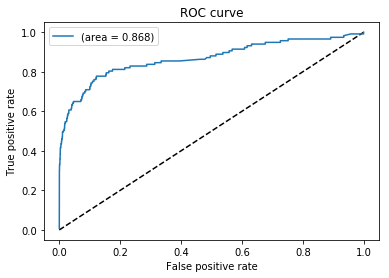


train:  (20521, 1394)  test:  (8795, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0498297
Early stopping, best iteration is:
[176]	valid_0's binary_logloss: 0.0497123

==== Testing best iteration ====
TN 8673 , FN 80 , FP 5 , TP 37
AUC =  0.856686423868
AUC_classifier =  0.657831573307
Acc: 0.990335417851


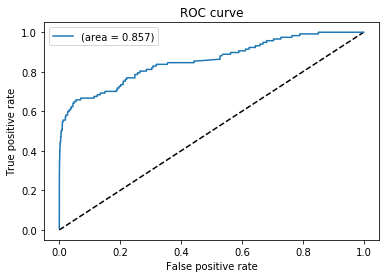


train:  (20521, 1394)  test:  (8795, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0486169
Early stopping, best iteration is:
[249]	valid_0's binary_logloss: 0.0482111

==== Testing best iteration ====
TN 8673 , FN 80 , FP 5 , TP 37
AUC =  0.878934943063
AUC_classifier =  0.657831573307
Acc: 0.990335417851


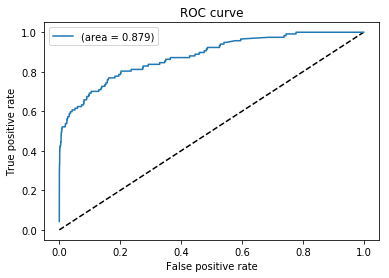

Plot feature importances...


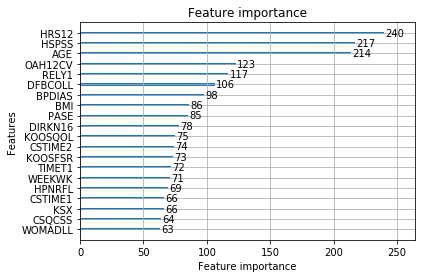

In [376]:
train_t3, target_t3 = getTimeSpecific(DATASET,time_t_to_predict=3,drop_censored=True,tg_name='target_ff')
#train_t3 = train_t3.drop(columns=least_important)
train_t3 = train_t3.drop(columns='VISDYS')

train_t3, test_t3, target_t3, test_target_t3 = train_test_split(train_t3,target_t3, test_size=0.3)

model_t3, test_pred_t3 = TrainAndTest(train_t3,target_t3,test_t3,test_target_t3, iterations=3)

plotImportances(model_t3)

### Analysis for Time 5 (probability of replacement in 5 years)


train:  (14060, 1394)  test:  (6026, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0767216
Early stopping, best iteration is:
[284]	valid_0's binary_logloss: 0.0754511

==== Testing best iteration ====
TN 5834 , FN 97 , FP 4 , TP 91
AUC =  0.867585263097
AUC_classifier =  0.741678693519
Acc: 0.983239296382


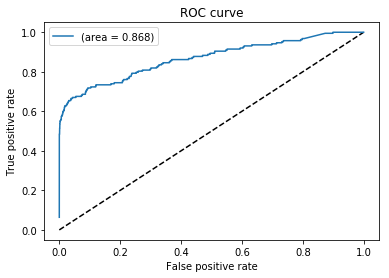


train:  (14060, 1394)  test:  (6026, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0766996
Early stopping, best iteration is:
[278]	valid_0's binary_logloss: 0.075346

==== Testing best iteration ====
TN 5834 , FN 95 , FP 4 , TP 93
AUC =  0.884340855583
AUC_classifier =  0.746997842456
Acc: 0.983571191503


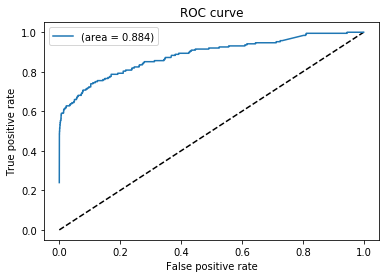


train:  (14060, 1394)  test:  (6026, 1394)
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.0757943
Early stopping, best iteration is:
[293]	valid_0's binary_logloss: 0.0745012

==== Testing best iteration ====
TN 5835 , FN 101 , FP 3 , TP 87
AUC =  0.882626573513
AUC_classifier =  0.731126041416
Acc: 0.982741453701


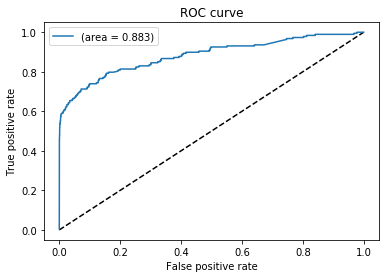

Plot feature importances...


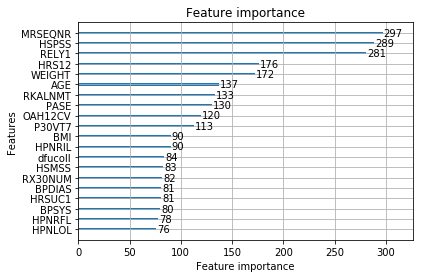

In [363]:
train_t5, target_t5 = getTimeSpecific(DATASET,time_t_to_predict=5,drop_censored=True,tg_name='target_ff')
#train_t5 = train_t5.drop(columns=least_important)
train_t5 = train_t5.drop(columns='VISDYS')

train_t5, test_t5, target_t5, test_target_t5 = train_test_split(train_t5,target_t5, test_size=0.3)

model_t5, test_pred_t5 = TrainAndTest(train_t5,target_t5,test_t5,test_target_t5, iterations=3)
plotImportances(model_t5)